# 单细胞 ATAC 测序

高通量稀疏的 ATAC-seq 数据需要无监督的分群和聚类，这种自举是具有挑战性的。我们一般通过等间距
切割位点矩阵进行无监督的降维和分群，这将基因组分割成数千万个小段，并近似表达矩阵

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em
em.setwd('/home/data/yangz/shared/tutorial/single-cell-atac')
ver = em.version()

[i] exprmat 0.1.48 / exprmat-db 0.1.48
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/single-cell-atac
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.48)
[i] resident memory: 808.93 MiB
[i] virtual memory: 5.78 GiB


In [4]:
! tree -sh ./src

./src
├── [4.0K]  atac
│   └── [2.5G]  atac-pbmc-fragments.tsv.gz
└── [4.0K]  gex
    ├── [ 53K]  barcodes.tsv.gz
    ├── [2.7M]  features.tsv.gz
    └── [394M]  matrix.mtx.gz

2 directories, 4 files


In [6]:
meta = em.metadata(
    locations    = [
        'src/atac/atac-pbmc-fragments.tsv.gz',
        'src/gex',
    ],
    modality     = ['atac', 'rna'],
    default_taxa = ['hsa/grch38', 'hsa/grch38'],
    batches      = ['b-1'] * 2,
    names        = ['multiome', 'multiome'],
    groups       = ['pbmc', 'pbmc'],
)

In [7]:
meta.dataframe

,location,sample,batch,group,modality,taxa
0,src/atac/atac-pbmc-fragments.tsv.gz,multiome,b-1,pbmc,atac,hsa/grch38
1,src/gex,multiome,b-1,pbmc,rna,hsa/grch38


In [8]:
expm = em.experiment(meta, dump = 'multiome')

[i] reading sample multiome [atac] ...
[i] reading sample multiome [rna] ...
[i] 939 genes (out of 36601) not in the reference gene list.
[i] total 35662 genes mapped. 35554 unique genes.


### 质量控制

对于这里的单细胞 RNA 与 ATAC 联合测序，我们需要分两个模态进行质量控制

In [12]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.20,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 10,
    doublet_method = 'scrublet',
    min_cells = 3,
    min_genes = 600
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 106 ribosomal genes
quality controlling sample [multiome] ...
raw dataset contains 10970 cells, 28858 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 18.4 %
[i] estimated detectable doublet fraction: 98.8 %
[i] overall doublet rate: 18.7 %
filtered dataset contains 7828 cells, 24898 genes


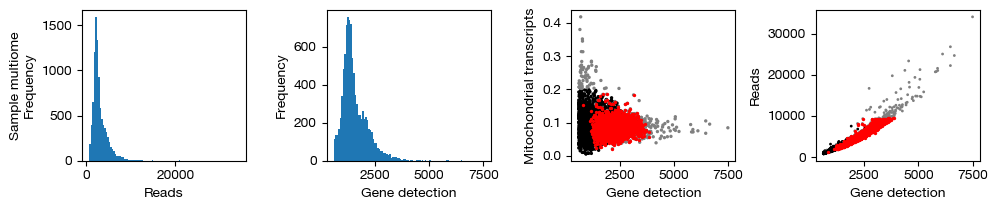

In [13]:
figs = expm.plot_rna_qc(run_on_samples = True)

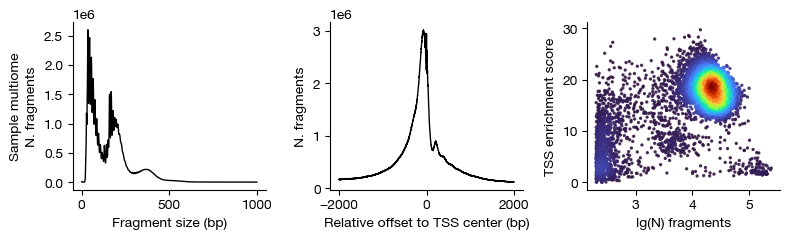

In [11]:
figs = expm.plot_atac_qc(run_on_samples = True)

In [14]:
expm.run_rna_filter(run_on_samples = True)
expm.run_atac_filter_cells(
    run_on_samples = True,
    min_counts = 5000, 
    min_tsse = 10, 
    max_counts = 100000
)

我们只保留质量高的 ATAC 细胞，这表现为检测到的片段数多而聚集在 TSS 处

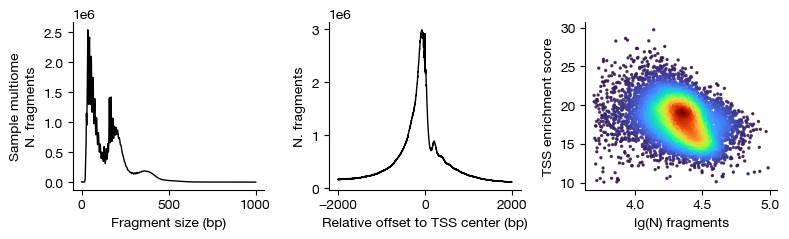

In [15]:
figs = expm.plot_atac_qc(run_on_samples = True)

In [16]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  multiome   atac  hsa/grch38   batch b-1     of size 9868 × 0
  multiome   rna   hsa/grch38   batch b-1     of size 7828 × 24898



### ATAC 片段矩阵的生成和聚类

如果将所有细胞产生的片段聚集在一起，这样的分析是没有意义的，我们需要了解每一种细胞类型特异性的
染色质可及性。然而，如果不能得到良好的分组，我们无法从如此稀疏的数据中决定细胞类型。我们需要一些
高性能的方法从及其大而稀疏的片段矩阵中推断相似性

现在，我们生成片段矩阵，默认在基因组上的每 500bp 生成一个片段

In [17]:
expm.run_atac_make_bins(run_on_samples = True)

In [19]:
expm['atac']['multiome'].obs

,n.fragments,pct.dup,pct.mito,barcode,ubc,tsse
multiome:1,22518,0.595487,0.0,multiome:AAACGAAAGAGAGGTA-1,multiome:1,19.423177
multiome:2,9019,0.499556,0.0,multiome:AAACGAAAGCAGGAGG-1,multiome:2,22.519364
multiome:3,28148,0.524141,0.0,multiome:AAACGAAAGGAAGAAC-1,multiome:3,17.890528
multiome:4,29126,0.570552,0.0,multiome:AAACGAAAGTCGACCC-1,multiome:4,19.469426
multiome:5,13124,0.562606,0.0,multiome:AAACGAACAAGCACTT-1,multiome:5,22.730108
...,...,...,...,...,...,...
multiome:11427,42232,0.446624,0.0,multiome:TTTGTGTTCTATACCT-1,multiome:11427,15.579201
multiome:11428,19064,0.511880,0.0,multiome:TTTGTGTTCTATCTCA-1,multiome:11428,18.225700
multiome:11429,24653,0.545801,0.0,multiome:TTTGTGTTCTCTATTG-1,multiome:11429,18.913518
multiome:11430,25610,0.485908,0.0,multiome:TTTGTGTTCTGATCTT-1,multiome:11430,15.025295


可以看见，人类基因组被切成了 606 万个 500bp 的片段

In [20]:
expm['atac']['multiome'].var

,chr,start,end,location,unique
bin:grch38:chr1:0-500,chr1,0,500,chr1:0-500,bin:grch38:chr1:0-500
bin:grch38:chr1:500-1000,chr1,500,1000,chr1:500-1000,bin:grch38:chr1:500-1000
bin:grch38:chr1:1000-1500,chr1,1000,1500,chr1:1000-1500,bin:grch38:chr1:1000-1500
bin:grch38:chr1:1500-2000,chr1,1500,2000,chr1:1500-2000,bin:grch38:chr1:1500-2000
bin:grch38:chr1:2000-2500,chr1,2000,2500,chr1:2000-2500,bin:grch38:chr1:2000-2500
...,...,...,...,...,...
bin:grch38:chrX:156038500-156039000,chrX,156038500,156039000,chrX:156038500-156039000,bin:grch38:chrX:156038500-156039000
bin:grch38:chrX:156039000-156039500,chrX,156039000,156039500,chrX:156039000-156039500,bin:grch38:chrX:156039000-156039500
bin:grch38:chrX:156039500-156040000,chrX,156039500,156040000,chrX:156039500-156040000,bin:grch38:chrX:156039500-156040000
bin:grch38:chrX:156040000-156040500,chrX,156040000,156040500,chrX:156040000-156040500,bin:grch38:chrX:156040000-156040500


类似于高可变基因的选择，我们需要从这个海量的片段中筛选掉绝大多数 0, 我们选择 250000 个高可变染色质区（对于转录物组，我们一般只用 1000 - 2000 个基因，这是因为总量的差异巨大）

In [21]:
expm.run_atac_select_features(
    run_on_samples = True,
    n_features = int(25e4)
)

使用改进的 scrublet 方法，我们可以高效的从 ATAC-seq 数据中得到混杂细胞

In [22]:
expm.run_atac_scrublet(
    run_on_samples = True,
    scrublet_init_args = { 'random_state': 42 }, 
    scrublet_args = {}
)

[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using spectrum ...
[i] calculating doublet scores ...
[i] detected doublet rate: 6.1 %
[i] estimated detectable doublet fraction: 72.3 %
[i] overall doublet rate: 8.4 %


In [23]:
expm.merge()
expm.save()

[i] main dataset write to multiome/integrated.h5mu
[i] saving individual samples. (pass `save_samples = False` to skip)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [atac]          1 / 1     (00:41 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [rna]           1 / 1     (00:00 < 00:00)


### 降维和聚类

我们使用 Spectral Embedding 对差异可及片段进行无监督聚类

In [3]:
expm = em.load_experiment('multiome')

   ------------------------------ loading samples          0 / 2     (00:00 < ?)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ loading samples          2 / 2     (01:12 < 00:00)


In [5]:
print(expm)

annotated data of size 7828 × 24898
annotated data of size 9868 × 6062095
integrated dataset of size 10963 × 6086993
contains modalities: rna, atac

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o>

 modality [atac]
    obs : n.fragments <ui64> pct.dup <f64> pct.mito <f64> barcode <o> ubc <o> tsse <f64>
          n.umi <ui64> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> sample <cat>
    var : chr <cat> start <cat> end <cat> location <o> unique <o> count <f64> selected <bool>
   obsm : paired <csr:ui32(3088286401)>
    uns : assembly assembly.size

[*] composed of samples:
  multiome   a

In [4]:
expm.run_atac_select_features(
    n_features = int(25e4)
)

In [6]:
expm.run_atac_spectral(
    n_comps = 30,
    features = "selected",
    random_state = 0,
    sample_size = None,
    sample_method = "random",
    chunk_size = 20000,
    distance_metric = "cosine",
    weighted_by_sd = True,
    feature_weights = None,
    key_added = 'spectral'
)

In [8]:
expm.run_atac_knn(
    use_rep = 'spectral',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "cosine",
    metric_kwds = {},
    random_state = 0,
    key_added = 'neighbors',
    n_jobs = -1
)

In [9]:
expm.run_atac_umap(n_components = 2, neighbors_key = 'neighbors')

In [11]:
expm.run_atac_leiden(
    resolution = 0.5
)

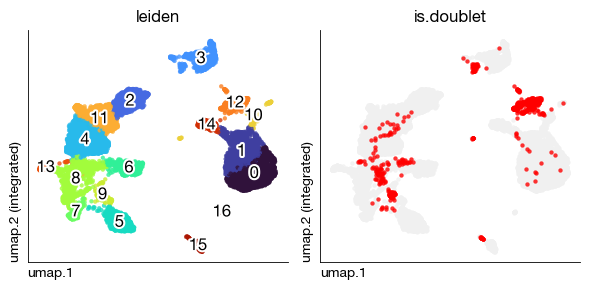

In [13]:
fig = expm.plot_atac_embedding_multiple(
    basis = 'umap', features = ['leiden', 'is.doublet'], ncols = 2, figsize = (6, 3),
    legend = False, annotate = True, annotate_style = 'text'
)

### 推断基因转录水平

从 ATAC-seq 推断基因转录水平便于与 RNA-seq 数据进行比对，这将会生成一个 atac-g 模态的推断表达矩阵
我们可以将这个推断矩阵与单细胞 RNA-seq 数据进行整合和投影。这个矩阵是非常稀疏的，也有相当的噪声，
一些适当的平滑算法可以被应用

In [14]:
expm.run_atac_infer_gene_activity()

In [15]:
print(expm)

annotated data of size 7828 × 24898
annotated data of size 9868 × 6062095
annotated data of size 9868 × 75716
integrated dataset of size 10963 × 6086993
contains modalities: rna, atac, atac-g

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o>

 modality [atac]
    obs : n.fragments <ui64> pct.dup <f64> pct.mito <f64> barcode <o> ubc <o> tsse <f64>
          n.umi <ui64> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> sample <cat>
          leiden <cat>
    var : chr <cat> start <cat> end <cat> location <o> unique <o> count <f64> selected <bool>
   obsm : paired <csr:ui32(3088286401)> spectr

In [18]:
expm['atac-g'].obs[['barcode', 'leiden']]

,barcode,leiden
multiome:1,multiome:AAACGAAAGAGAGGTA-1,0
multiome:2,multiome:AAACGAAAGCAGGAGG-1,2
multiome:3,multiome:AAACGAAAGGAAGAAC-1,3
multiome:4,multiome:AAACGAAAGTCGACCC-1,4
multiome:5,multiome:AAACGAACAAGCACTT-1,4
...,...,...
multiome:11427,multiome:TTTGTGTTCTATACCT-1,1
multiome:11428,multiome:TTTGTGTTCTATCTCA-1,5
multiome:11429,multiome:TTTGTGTTCTCTATTG-1,7
multiome:11430,multiome:TTTGTGTTCTGATCTT-1,1


In [20]:
expm['atac-g'].var[['chr', 'strand', 'start', 'end', 'gene', 'assembly']]

,chr,strand,start,end,gene,assembly
rna:hsa:g78927,chrY,-,57212184,57214397,DDX11L16,grch38
rna:hsa:g63727,chr1,+,12010,13670,DDX11L1,grch38
rna:hsa:g63728,chr1,-,14696,24886,WASH7P,grch38
rna:hsa:g3,chr1,-,17369,17436,MIR6859-1,grch38
rna:hsa:g4,chr1,+,28589,31109,MIR1302-2HG,grch38
...,...,...,...,...,...,...
rna:hsa:g78919,chrY,-,26586642,26591601,SLC25A15P1,grch38
rna:hsa:g78920,chrY,-,26594851,26634652,PARP4P1,grch38
rna:hsa:g78921,chrY,-,26626520,26627159,CCNQP2,grch38
rna:hsa:g78922,chrY,+,56855244,56855488,CTBP2P1,grch38


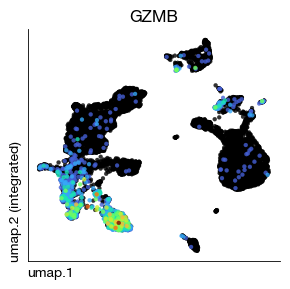

In [24]:
fig = expm.plot_atacg_embedding(
    basis = 'umap', color = 'GZMB', figsize = (3, 3)
)

现在我们通过 MAGIC 方法平滑化表达矩阵

In [25]:
expm.run_atacg_impute_magic(
    key_added = 'magic', solver = 'approximate', t = 'auto', 
    random_state = 42, n_jobs = 1, n_pca = 30, knn = 15
)

[i] running MAGIC on 9868 cells and 75716 genes.
Calculating PCA...
Calculated PCA in 29.12 seconds.
Calculating KNN search...
Calculated KNN search in 2.04 seconds.
Calculating affinities...
Calculated affinities in 2.01 seconds.
[i] automatically selected t = 5


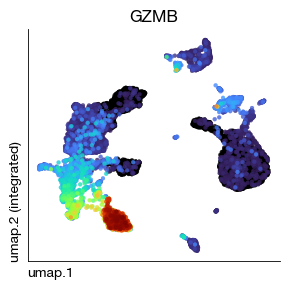

In [26]:
fig = expm.plot_atacg_embedding(
    slot = 'magic',
    basis = 'umap', color = 'GZMB', figsize = (3, 3)
)

### 分组 Peak Calling

我们根据无监督分群得到的同质细胞群体对片段进行整合，得到具体细胞类型的峰检出结果

In [27]:
expm.run_atac_call_peaks(
    # call peaks from fragments
    groupby = 'leiden',
    qvalue = 0.05,
    call_broad_peaks = False,
    broad_cutoff = 0.1,
    replicate = None,
    replicate_qvalue = None,
    max_frag_size = 180,  # only call nucleosome-free fragments 
    selections = None,
    nolambda = False,
    shift = -100,
    extsize = 200,
    min_len = None,
    blacklist = None,
    # directly call groups of peaks
    key_added = 'peaks.leiden',
    inplace = True,
    n_jobs = 30
)

[i] exporting fragments ...
[i] calling peaks ...


例如，对于 Leiden 聚类 0，我们可以检出如下峰

In [28]:
expm['atac'].uns['peaks.leiden']['0']

,chr,start,end,peak,score,strand,fc,p,q,summit
0,chr1,191398,191635,.,74,.,5.029644,9.458000,7.463389,118
1,chr1,191723,191969,.,179,.,8.103314,20.096550,17.967773,124
2,chr1,267868,268140,.,587,.,17.324327,61.091999,58.710663,135
3,chr1,271172,271442,.,237,.,9.408602,25.951559,23.772482,133
4,chr1,274281,274532,.,138,.,6.985616,15.980060,13.894191,124
...,...,...,...,...,...,...,...,...,...,...
118092,chrY,21421880,21422568,.,857,.,21.212120,88.202003,85.715759,504
118093,chrY,21440574,21440881,.,414,.,13.691807,43.721760,41.425930,152
118094,chrY,21481589,21481870,.,211,.,8.941588,23.339609,21.181503,137
118095,chrY,56839520,56839823,.,22,.,3.073671,4.092770,2.230723,95


我们对数据集的所有峰进行整合，并导出峰矩阵

In [29]:
expm.run_atac_merge_peaks(
    key_added = 'peaks.merged',
    key_groups = 'peaks.leiden',  
    groupby = 'leiden',
    flavor = 'snapatac'
)

In [30]:
expm.run_atac_make_peak_matrix(
    chunk_size = 500,
    min_frag_size = None,
    max_frag_size = 180,
    counting_strategy = 'paired-insertion',
    value_type = 'target',
    summary_type = 'sum'
)

In [31]:
expm.run_atacp_filter_column_by_sum(min_sum = 3)

我们可以观察到，在不同细胞类型中，标记基因上的开放程度具有显著差异

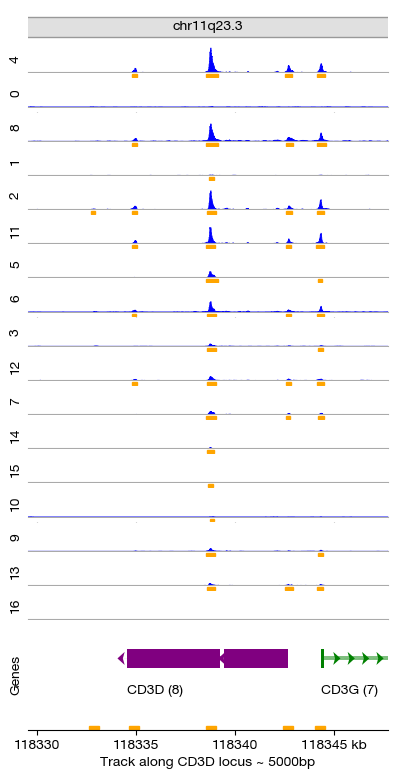

In [33]:
figs = expm.plot_atac_peaks(
    group_key = 'leiden', peaks_key = 'peaks.leiden',
    # either specifying a gene name for convenience
    gene = 'CD3D', upstream = 5000, downstream = 5000, 
    # or specify chromosome coordinates manually
    chr = None, xf = None, xt = None, 
    figsize = (4, 8), dpi = 100, 
    gene_track_height = 0.15, chrom_track_height = 0.05,  
    peak_annotation_height = 0.15,
    min_frag_length = None, max_frag_length = 180,
    title = 'Track along CD3D locus ~ 5000bp', showgn = True,
    plot_consensus_peak = 'peaks.merged'
)

### 基础细胞类型的注释

我们可以基于推断的表达矩阵进行细胞类型的初步注释，这和 RNA-seq 的注释类型显然会有所不同，但是
总体分群是可以确定的，ATAC-seq 和 RNA-seq 可以构成互补的分群标准

In [ ]:
fig = expm.plot_atacg_embedding_multiple(
    slot = 'magic',
    basis = 'umap', figsize = (7.5, 10),
    features = [
        'CD4', 'CD8A', 'KLRC1',
        'PTPRC', 'CD19', 'IGHG1',
        'CD79A', 'CPA3', 'VCAN',
        'CD14', 'KLF7', 'leiden'
    ], ncols = 3, legend = False, annotate_style = 'text'
)

In [14]:
expm.run_atacg_markers_deseq(
    counts = 'X',
    metadata = ['sample', 'leiden'], formula = '~ leiden',
    variable = 'leiden', experiment = '6', control = '8',
    key_added = 'markers'
)

[i] fitting size factors ...
[i] using None as control genes, passed at deseq_dataset initialization
[i]   done in 13.73 seconds.
[i] fitting dispersions...
[i]   done in 49.76 seconds.
[i] fitting dispersion trend curve ...
[!] the dispersion trend curve fitting did not converge. 
[!] switching to a mean-based dispersion trend.
[i]   done in 1.18 seconds.
[i] fitting map dispersions ...
[i]   done in 55.07 seconds.
[i] fitting log fold changes ...
[i]   done in 46.31 seconds.
[i] calculating cook's distance ...
[i]   done in 46.98 seconds.
[i] replacing 257 outlier genes.
[i] fitting dispersions...
[i]   done in 0.47 seconds.
[i] fitting map dispersions ...
[i]   done in 0.52 seconds.
[i] fitting log fold changes ...
[i]   done in 0.46 seconds.


In [15]:
expm.get_atacg_markers().head(20)

[i] fetched diff `6` over `8` (333 genes)


,mean,lfc,lfc.se,scores,p,q,names,gene,log10.p,log10.q
52327,2.481912,1.993741,0.066726,29.879652,3.617562e-196,3.819784e-192,rna:hsa:g17763,ACTN1,195.441584,191.417961
56139,2.193997,2.794655,0.099639,28.047879,4.239642e-173,3.357479e-169,rna:hsa:g21043,ENSG00000259199,172.372671,168.473987
11465,3.268279,1.908859,0.068298,27.948908,6.796815e-172,4.306054e-168,rna:hsa:g35282,KLF7,171.167695,167.365921
56142,1.430376,2.772263,0.101508,27.310866,3.151399e-164,1.663781e-160,rna:hsa:g21046,ARRDC4,163.501497,159.778904
2314,1.327946,2.406478,0.096413,24.960166,1.656240e-137,4.035746e-134,rna:hsa:g2024,CACHD1,136.780877,133.394076
18445,2.557663,1.619078,0.065177,24.841230,3.216522e-136,7.277840e-133,rna:hsa:g45134,LEF1,135.492613,132.137997
70437,4.706824,1.543288,0.062210,24.807883,7.370320e-136,1.556464e-132,rna:hsa:g38251,TIAM1,135.132514,131.807861
29843,0.796094,3.143126,0.128924,24.379642,2.812191e-131,4.688515e-128,rna:hsa:g54429,GNAI1,130.550955,127.328965
67329,0.643251,2.774769,0.118852,23.346511,1.495358e-120,2.059498e-117,rna:hsa:g30880,CLEC11A,119.825255,116.686239
36176,2.630461,1.724968,0.076006,22.695006,5.018818e-114,5.888189e-111,rna:hsa:g59633,PCSK5,113.299399,110.230018


In [ ]:
expm.annotate(
    slot = 'atac-g',
    mapping = {
        'CD14 Mo': [0, 1, 14, 10],
        'Db': [12, 16],
        'B': [3],
        'CD4 T': [4, 6, 11, 2],
        'CD8 T': [7, 8, 9, 13],
        'NK': [5],
        'Mast': [15]
    }
)

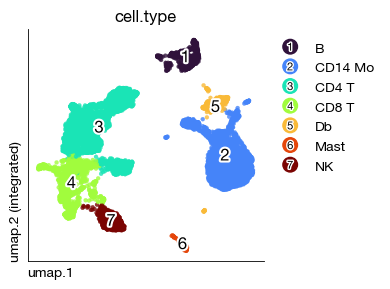

In [19]:
fig = expm.plot_atacg_embedding(
    slot = 'magic',
    basis = 'umap', color = 'cell.type', figsize = (4, 3)
)

In [21]:
expm['atac'].obs['cell.type'] = expm['atac-g'].obs['cell.type']

In [23]:
expm.run_atac_call_peaks(
    # call peaks from fragments
    groupby = 'cell.type',
    qvalue = 0.05,
    call_broad_peaks = False,
    broad_cutoff = 0.1,
    replicate = None,
    replicate_qvalue = None,
    max_frag_size = 180,  # only call nucleosome-free fragments 
    selections = None,
    nolambda = False,
    shift = -100,
    extsize = 200,
    min_len = None,
    blacklist = None,
    # directly call groups of peaks
    key_added = 'peaks.ctype',
    inplace = True,
    n_jobs = 30
)

[i] exporting fragments ...
[i] calling peaks ...


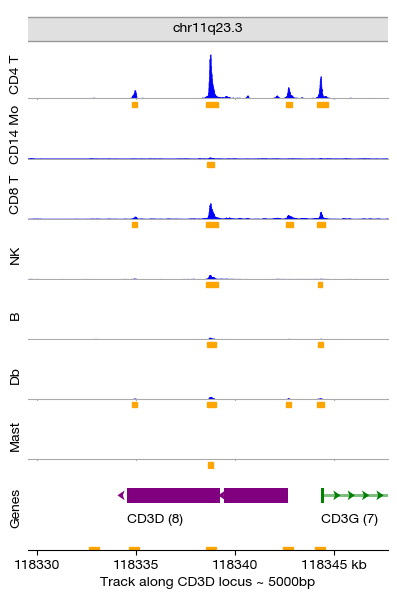

In [26]:
figs = expm.plot_atac_peaks(
    group_key = 'cell.type', peaks_key = 'peaks.ctype',
    # either specifying a gene name for convenience
    gene = 'CD3D', upstream = 5000, downstream = 5000, 
    # or specify chromosome coordinates manually
    chr = None, xf = None, xt = None, 
    figsize = (4, 6), dpi = 100, 
    gene_track_height = 0.15, chrom_track_height = 0.075,  
    peak_annotation_height = 0.15,
    min_frag_length = None, max_frag_length = 180,
    title = 'Track along CD3D locus ~ 5000bp', showgn = True,
    plot_consensus_peak = 'peaks.merged'
)

### 保存数据

现在保存我们进行预处理的矩阵

In [34]:
print(expm)

annotated data of size 7828 × 24898
annotated data of size 9868 × 6062095
annotated data of size 9868 × 75716
annotated data of size 9868 × 207908
integrated dataset of size 10963 × 6086993
contains modalities: rna, atac, atac-g, atac-p

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o>

 modality [atac]
    obs : n.fragments <ui64> pct.dup <f64> pct.mito <f64> barcode <o> ubc <o> tsse <f64>
          n.umi <ui64> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> sample <cat>
          leiden <cat>
    var : chr <cat> start <cat> end <cat> location <o> unique <o> count <f64> selected <bool>
 

In [27]:
expm.save()

[i] main dataset write to multiome/integrated.h5mu
[i] saving individual samples. (pass `save_samples = False` to skip)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [atac]          1 / 1     (00:34 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [rna]           1 / 1     (00:00 < 00:00)
